In [56]:
# 導入函式庫以及讀取資料
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np

df = pd.read_csv("water_potability.csv")

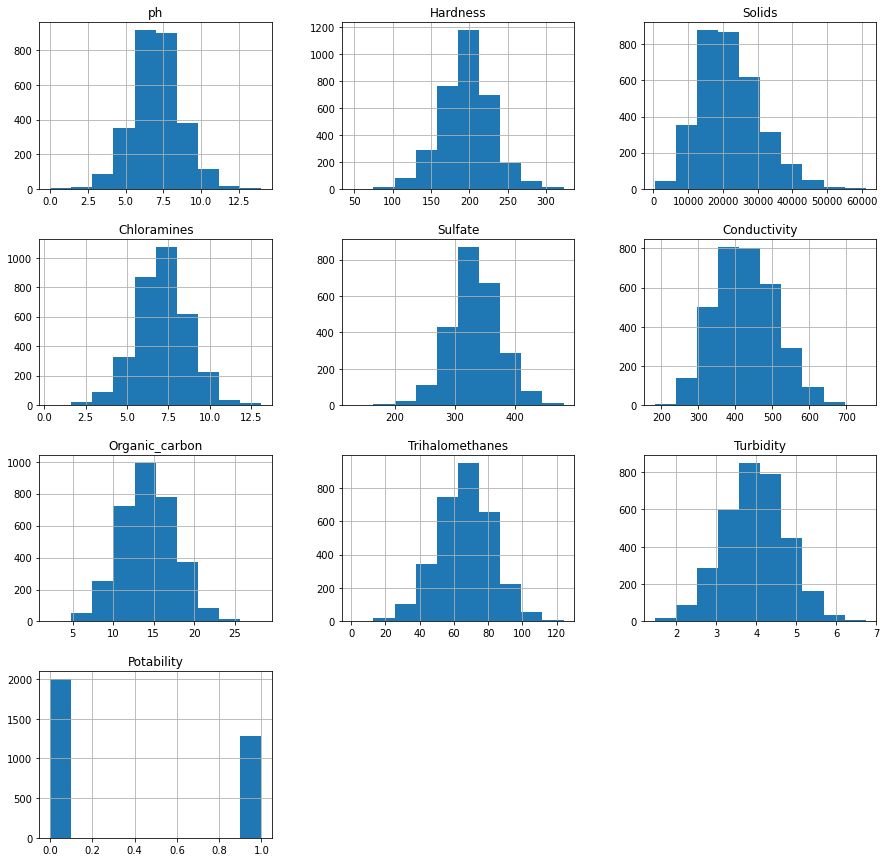

In [57]:
df.hist(figsize=(15, 15))
plt.show()

<AxesSubplot:>

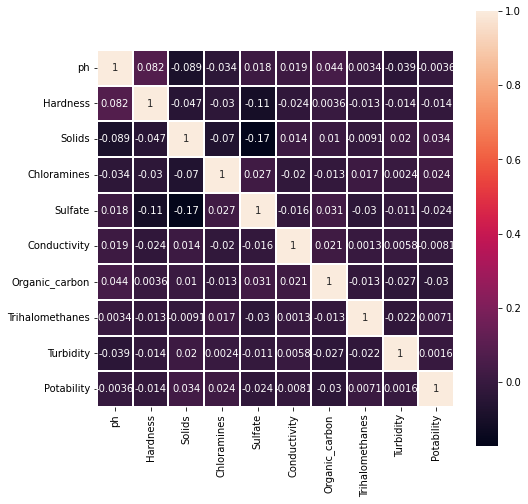

In [58]:
from numpy import true_divide

plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, linewidths=1, square=True)

In [59]:
# 填補空缺值
empty = df.columns[df.isna().any()].tolist()
print("有空缺的資料：", empty)
print("填補空缺值...")
for i in empty:
    df[i].fillna(value=df[i].median(), inplace=True)
print("確認填補結果：")
print(df.isnull().sum())

有空缺的資料： ['ph', 'Sulfate', 'Trihalomethanes']
填補空缺值...
確認填補結果：
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [60]:
'''
我們有一個包含水質數據的數據框（DataFrame），
其中每一行代表一個樣本（例如一個水樣品），每一列包含相應樣本的不同屬性或特徵，
最後一列是我們想要預測的目標變數（"Potability"，即水是否適合飲用）
'''
# 切分特徵和目標變量
X = df.drop("Potability", axis=1)
y = df["Potability"]
# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

{'max_depth': 7, 'max_features': 9}
0.6404580152671755

DecisionTree Accuracy: 0.6463414634146342

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       412
           1       0.55      0.28      0.37       244

    accuracy                           0.65       656
   macro avg       0.61      0.57      0.56       656
weighted avg       0.62      0.65      0.61       656



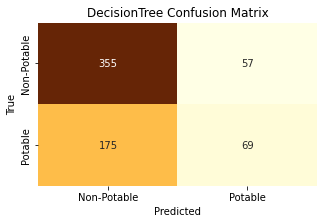

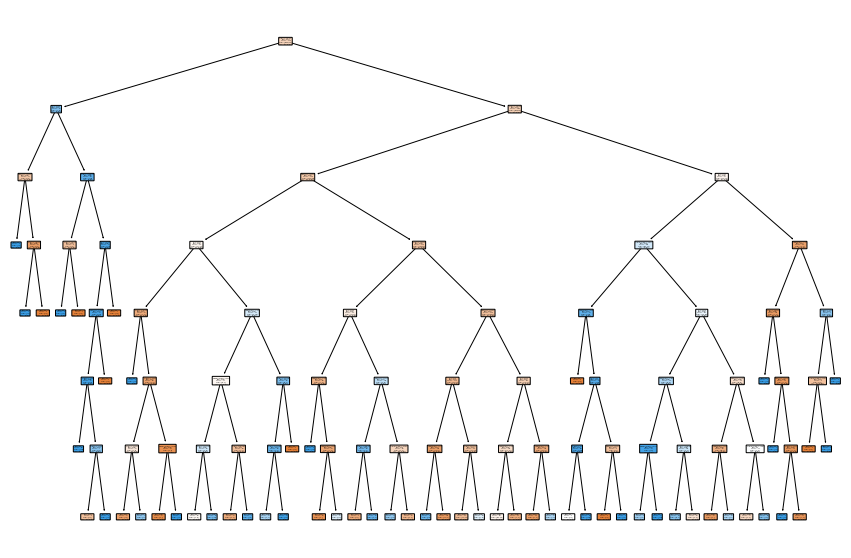

Cross-Validation Scores: [0.58384146 0.62290076 0.62900763 0.58015267 0.63969466]
Mean Accuracy: 0.6111194377210948


In [61]:
#決策樹
#對水質數據進行分類
'''
在機器學習中，超參數是在模型擬合之前需要手動設定的參數，而不是由模型自動學習的參數。
決策樹有一些超參數，例如樹的深度 (max_depth) 和每個節點最大特徵數 (max_features) 等，這些超參數的設定會影響模型的性能。
通常情況下，我們不知道哪組超參數值是最佳的，因此我們使用網格搜索來通過在指定的超參數範圍內嘗試不同的組合，從而找到最佳的超參數組合。
這樣做的好處是，可以自動化地找到最佳超參數，而不需要手動進行不斷的調整。這有助於提高模型的性能，使其更能適應數據並提高預測能力。
'''
'''
這裡使用網格搜索 (GridSearchCV) 來尋找最佳的 K 值。
定義了一個 K 值的範圍（1 到 101），然後使用網格搜索在這個範圍內尋找最佳的 K 值。
GridSearchCV 通過交叉驗證（cv=5）來評估每個 K 值的性能。
最後，印出最佳的 K 值和對應的交叉驗證分數。
'''

# 定義決策樹模型的超參數範圍
DecisionTree_model_param={'max_depth':[i for i in range(1,21)],'max_features':[i for i in range(1, len(X.columns) + 1)]}

# 使用網格搜索(GridSearchCV)尋找最佳超參數
DecisionTree_grid_search=GridSearchCV(DecisionTreeClassifier(),DecisionTree_model_param,cv=5)
DecisionTree_grid_search.fit(X_train,y_train)
print(DecisionTree_grid_search.best_params_) # 輸出最佳超參數
print(DecisionTree_grid_search.best_score_) # 輸出最佳模型的交叉驗證分數
best_param=DecisionTree_grid_search.best_params_

#建立決策樹模型
DecisionTree_model = DecisionTreeClassifier(max_features=best_param['max_features'],max_depth=best_param['max_depth'])
DecisionTree_model.fit(X_train, y_train)

#進行預測
y_pred = DecisionTree_model.predict(X_test)

# 評估模型性能
DecisionTree_accuracy = accuracy_score(y_test, y_pred)
print(f"\nDecisionTree Accuracy: {DecisionTree_accuracy}\n")

# 分類報告
DecisionTree_class_report = classification_report(y_test, y_pred)
print("DecisionTree Classification Report:")
print(DecisionTree_class_report)

# 混淆矩陣
DecisionTree_conf_matrix = confusion_matrix(y_test, y_pred)

# 使用Seaborn來繪製熱力圖
plt.figure(figsize=(5, 3))
sns.heatmap(DecisionTree_conf_matrix, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
            xticklabels=["Non-Potable", "Potable"],
            yticklabels=["Non-Potable", "Potable"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DecisionTree Confusion Matrix')
plt.show()

# 特徵名稱
feature_names = X.columns.tolist()

# 可視化決策樹
plt.figure(figsize=(15, 10))
plot_tree(DecisionTree_model, feature_names=feature_names, class_names=["Non-Potable", "Potable"], filled=True, rounded=True)
plt.show()

# 交叉驗證，評估模型的穩健性
DecisionTree_cross_val_scores = cross_val_score(DecisionTree_model, X, y, cv=5)
print(f"Cross-Validation Scores: {DecisionTree_cross_val_scores}")
print(f"Mean Accuracy: {DecisionTree_cross_val_scores.mean()}")

{'n_neighbors': 16}
0.6473282442748092

KNN Accuracy: 0.6692073170731707

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       412
           1       0.63      0.27      0.37       244

    accuracy                           0.67       656
   macro avg       0.65      0.59      0.57       656
weighted avg       0.66      0.67      0.63       656



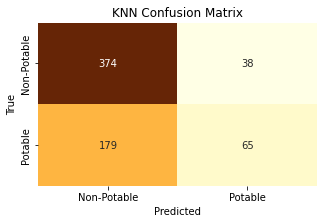


Cross-Validation Scores: [0.59146341 0.58931298 0.60916031 0.59389313 0.59083969]
Mean Accuracy: 0.594933904300875


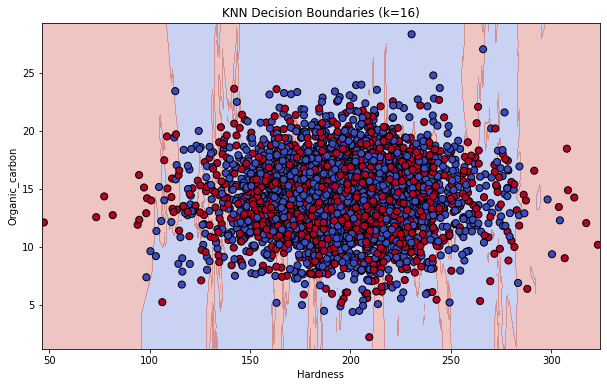

In [62]:
#KNN

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
這裡使用網格搜索 (GridSearchCV) 來尋找最佳的 K 值。
定義了一個 K 值的範圍（1 到 101），然後使用網格搜索在這個範圍內尋找最佳的 K 值。
GridSearchCV 通過交叉驗證（cv=5）來評估每個 K 值的性能。
最後，印出最佳的 K 值和對應的交叉驗證分數。
'''

# 定義決策樹模型的超參數範圍
Knn_model_param = {'n_neighbors': range(1, 21)}

# 使用網格搜索尋找最佳K值
Knn_grid_search = GridSearchCV(KNeighborsClassifier(), Knn_model_param, cv=5)
Knn_grid_search.fit(X_train_scaled, y_train)
print(Knn_grid_search.best_params_)
print(Knn_grid_search.best_score_)
best_k = Knn_grid_search.best_params_['n_neighbors']

# 使用最佳K值擬合新的KNN模型
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# 預測
y_pred_best = knn_model.predict(X_test_scaled)

# 評估模型性能
Knn_accuracy = accuracy_score(y_test, y_pred_best)
Knn_classification_rep = classification_report(y_test, y_pred_best)

# 分類報告
print(f'\nKNN Accuracy: {Knn_accuracy}\n')
print(f'KNN Classification Report:\n{Knn_classification_rep}')

# 使用Seaborn來繪製混淆矩陣
Knn_conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 3))
sns.heatmap(Knn_conf_matrix, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
            xticklabels=["Non-Potable", "Potable"],
            yticklabels=["Non-Potable", "Potable"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

# 交叉驗證
cv_val_scores = cross_val_score(knn_model, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_val_scores}")
print(f"Mean Accuracy: {cv_val_scores.mean()}")


# 取Hardness和Organic_carbon特徵用於可視化
'''如果水中鈣和鎂離子的濃度較高，則水的硬度也相對較高
水體来源：
如果水體源自相似的地質區域，地下水中的礦物質可能同時影響硬度和有機碳的濃度。
例如，地質中豐富的碳酸鈣可能提高水的硬度，同時地下水流經有機質豐富的土壤可能導致水中有機碳的增加。

人為活動：
農業和工業活動可能同時導致水中有機碳和硬度的變化。例如，農業過程中使用的肥料可能引入有機物和養分，同時礦物的流入也可能提高水的硬度。

自然處理過程：
自然的地下水循環和生態系統的相互作用可能導致硬度和有機碳的變化。
地下水流通過地層時可能溶解礦物質，影響硬度，同時地表水中的生態作用和分解可能影響有機碳的濃度。

水體中的微生物活動：
水中的微生物可能同時受到硬度和有機碳的影響。有機碳提供了微生物生長的營養源，而硬度可能影響某些微生物的生態。
'''
import numpy as np

'''
從原始特徵中選取 'Hardness' 和 'Organic_carbon' 這兩個特徵，用於後面的模型可視化。
同時，建立一個新的 KNN 模型（knn_vis）並使用這兩個特徵進行訓練。
'''

X_2d = X[['Hardness', 'Organic_carbon']]

# 設定模型和參數
knn_vis = KNeighborsClassifier(n_neighbors=best_k)

# 訓練模型
knn_vis.fit(X_2d, y)

# 繪製決策邊界

'''
建立一個二維網格，並使用 KNN 模型對網格中的點進行預測，最終為這個網格上的每個點劃分一個預測類別。
'''

# 設定網格的步長
h = .02

# 設定 x 和 y 軸的範圍
x_min, x_max = X_2d.iloc[:, 0].min() - 1, X_2d.iloc[:, 0].max() + 1
y_min, y_max = X_2d.iloc[:, 1].min() - 1, X_2d.iloc[:, 1].max() + 1

# 建立網格
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 將網格中的點展平，並使用模型進行預測
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])

# 將預測結果 reshape 回網格形狀
Z = Z.reshape(xx.shape)

# 繪製數據點和決策邊界
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_2d.iloc[:, 0], X_2d.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=50)
plt.xlabel('Hardness')
plt.ylabel('Organic_carbon')
plt.title(f'KNN Decision Boundaries (k={best_k})')
plt.show()